<a href="https://colab.research.google.com/github/KaroAntonio/climate-social-analysis/blob/main/notebooks/Climate_Conversation_Topic_Modelling_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Climate Conversation Topic Modelling - EDA

Here we conduct EDA and get a statistical understanding of the features and distributions of our climate tweet data.

We want to keep our primary Data Problem in mind:   

*What Topics can be extracted from climate tweets and how can the relevance of those topics be measured.*

This is an unsupervised clustering problem.

**Climate Tweet Dataset Characteristics:**.
* N unique Tokens = ~250k
* Mean chars per tweet = 140
* N = 1m


**EDA Steps Taken in this Analysis:**

* Load Dataset & Tokens
* Explore most common tokens
* Lemmatize
* Explore token Vectors
* Perform PCA Visualization of corpus

**Possible Next Explorations:**
* Filter for language
* Get the TF-IDF for each token/tweet



**Summary of Findings:**  
Our primary goal in this EDA for Topic Modelling is to better understand the strcuture of the tweets and tokens. The tokens have a very broad lexicon and include many nonsense-ish tokens, so we want to understand how prevalent those are and if we can remove them. We found ~250k unique tokens originally. Out of 1m total tweets, that's a very high prevalence of random tweets. So we took several steps to reduce that count. This is somewhat of a further data cleanup step that might have been done in wrangling, but with text, of course EDA<>Cleaning is very iterative. We lemmatized tokens, removed all tokens that occured < 5 times, and removed stopwords. This reduced our unique token count to 20k-30k which is a bit more manageable. Still too high for each token to be a one-hot feature though. So in order to reduce dimensionality and to have directly comparable vectors for each tweet, we used a pre-trained word2vec model to get the vec embeddings for each token which we took the mean of to get tweet embeddings. Taking the mean of the token embeddings has pros/cons but a bit of spot testing showed that at least some info from the tokens was retained. Using these tweet vectors, we applied PCA to use in pairplots to assess the first several PCA components along with some very rudimentary categories to check what sort of structure exists if any. We found PCA to have significantly distinguished clusters which indicates that the vectors and most common tokens are likely useful features. We explored TF-IDF, but found the scores not to be very indicative because of how short each doc/tweet is. It might be more useful to apply TF-IDF to assess Topics that are modelled.

In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')
drive.mount('/content/drive')
word2vec_model = api.load("word2vec-google-news-300")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Data paths
DRIVE_DIR = "/content/drive/MyDrive/Climate Social Analysis/data/"
TWEET_TEXT_DATA_PATH = f"{DRIVE_DIR}climate-change-twitter-dataset-tweet-data.csv"
TWEET_TIMESTAMPS_DATA_PATH = f"{DRIVE_DIR}climate-change-twitter-dataset-timestamps.csv"
PREPROCESSED_TEXT_PATH = f"{DRIVE_DIR}preprocessed_text.csv"

In [3]:
# Load Data
text_df = pd.read_csv(TWEET_TEXT_DATA_PATH, index_col=0)
timestamps_df = pd.read_csv(TWEET_TIMESTAMPS_DATA_PATH, index_col=0)

In [4]:
# Load the the preprocessed and tokenized text data that we wrangled
preprocessed_df = pd.read_csv(PREPROCESSED_TEXT_PATH, index_col=0)

In [5]:
# We have 1m rows
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 1046036754304827395 to 997414075406700544
Data columns (total 1 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   processed_tokens_str  1000000 non-null  object
dtypes: object(1)
memory usage: 15.3+ MB


In [6]:
# We had saved the token arrays as strings so csv could handle them easily
tokens_sr = preprocessed_df['processed_tokens_str'].apply(lambda x: x.split())

In [7]:
# Validate that joining worked as expected
tokens_sr.head()

id
1046036754304827395    [constitution, support, gunsense, immigration,...
918531627944501249     [climate, between, ?, ages, change, was, there...
1855840046             [such, girly, leave, defeat, state, is, global...
951879018961399809     [!, climate, this, we, didnt, is, coming, chan...
1042533879209291777    [change, gas, great, paris, and, shareholder, ...
Name: processed_tokens_str, dtype: object

In [8]:
# Let's explore the Token Freqs again
tokens_list = tokens_sr.tolist()
all_tokens_list = [token for tokens in tokens_list for token in tokens]
freq_dist = FreqDist(all_tokens_list)

In [9]:
# How many unqiue tokens do we have?
print(f'We have {len(freq_dist.keys())} unique tokens')
# this is quite a few tokens, let's try to reduce that

We have 270715 unique tokens


In [10]:
# Is the lemmatization of the tokens an issue?
# let's explore some of the most common potential lemmatization issues
#freq_dist.most_common(100)
#How about 'scientist'?
print(f'scientists: {freq_dist["scientists"]}')
print(f'scientist: {freq_dist["scientist"]}')
# There is a significant portion of the distribution split between two different tokens

scientists: 19633
scientist: 5373


In [11]:
# Let's lemmatize the tokens and compare the freq_dist size
lemmatizer = WordNetLemmatizer()
lemmatized_tokens_sr = tokens_sr.apply(lambda tokens: [lemmatizer.lemmatize(t) for t in tokens])

In [12]:
# Let's explore the Token Freqs again
all_lemmatized_tokens = [token for tokens in lemmatized_tokens_sr.tolist() for token in tokens]
lemmatized_freq_dist = FreqDist(all_lemmatized_tokens)

In [13]:
# Check the # of lemmatized tokens
print(f'We have {len(lemmatized_freq_dist.keys())} lemmatized tokens')
# We reduced our unique tokens by only 10k! But possibly they were useful tokens

We have 259655 lemmatized tokens


In [14]:
# Let's recheck 'scientist'?
print(f'scientists: {lemmatized_freq_dist["scientists"]}')
print(f'scientist: {lemmatized_freq_dist["scientist"]}')
# nice

scientists: 0
scientist: 25008


<Axes: title={'center': 'Count of n tokens by token frequency'}, xlabel='token_freq'>

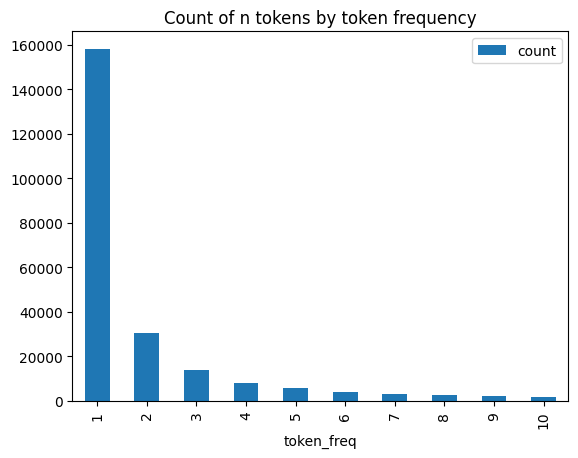

In [15]:
# What is the dist of our rare words?
# How many tokens do we have that have a freq of one, two, etc.
freq_freq_dist = FreqDist(lemmatized_freq_dist.values())
freq_freqs_df = pd.DataFrame(freq_freq_dist.most_common(10), columns=['token_freq','count'])
freq_freqs_df.plot(x='token_freq', y='count', kind='bar', title='Count of n tokens by token frequency')

In [16]:
# Based on the above Let's remove all tokens that occur <= 5 times
filtered_tokens_sr = lemmatized_tokens_sr.apply(lambda tokens: [t for t in tokens if lemmatized_freq_dist[t] > 5])

In [17]:
# It might be helpful to remove stopwords,
# however we might want to be cautious not to remove stopwords
# with relevant info like 'not'
# is 'not' a stopword?
english_stopwords = set(stopwords.words('english'))
print(f'Is "not" a stopword? {("not" in english_stopwords)}')
print(f'There are {len(english_stopwords)} english stopwords')

Is "not" a stopword? True
There are 179 english stopwords


In [18]:
# Filter out Stopwords
filtered_tokens_sr = filtered_tokens_sr.apply(lambda tokens: [t for t in tokens if t not in english_stopwords])

In [19]:
# In order to run PCA on the corpus, we need lower dimensionality representations.
# We have a couple options:
# - with one-hot tokens as cols,
#   we might be able to get the dims down
#   to a few thousand by choosing only the most common
# - with Word2Vec, we would be able to get down to dims(100)

In [20]:
# Let's use pre-trained word vecs
pre_trained_word_vectors = word2vec_model

In [21]:
# Let's test what the closest word to 'climate' is
climate_v = pre_trained_word_vectors['climate']
closest_words = pre_trained_word_vectors.similar_by_vector(climate_v, topn=10)
closest_words
# This looks reasonable

[('climate', 1.0),
 ('climate_change', 0.6569507122039795),
 ('Climate', 0.6230838894844055),
 ('climates', 0.6195024847984314),
 ('global_warming', 0.6047458648681641),
 ('environment', 0.6009922027587891),
 ('climatic', 0.5555011630058289),
 ('climatic_conditions', 0.5207005143165588),
 ('ambassador_Brice_Lalonde', 0.5172268152236938),
 ('Global_warming', 0.5048916339874268)]

In [22]:
# Let's remove all words that are not in the pre-trained word vecs
filtered_tokens_sr = filtered_tokens_sr.apply(lambda tokens: [t for t in tokens if t in pre_trained_word_vectors])

In [23]:
# Do we have a resonable number of tokens left per tweet? Looks like it
filtered_tokens_sr.apply(len).describe()

count    1000000.000000
mean          10.730417
std            4.992766
min            0.000000
25%            7.000000
50%           10.000000
75%           13.000000
max          116.000000
Name: processed_tokens_str, dtype: float64

In [24]:
# Keep only tweets with at least 1 token
filtered_tokens_sr = filtered_tokens_sr[filtered_tokens_sr.apply(len) > 0]

In [25]:
# Now that we've removed many of the less  meaningful words,
# let's explore the freq dists again
all_filtered_tokens = [token for tokens in filtered_tokens_sr.tolist() for token in tokens]
filtered_tokens_freqs = FreqDist(all_filtered_tokens)
filtered_tokens_freqs.most_common(20)

[('climate', 721756),
 ('change', 713771),
 ('global', 344714),
 ('warming', 328893),
 ('via', 45250),
 ('u', 45155),
 ('world', 41476),
 ('ha', 38787),
 ('say', 38257),
 ('people', 37981),
 ('new', 35692),
 ('like', 35662),
 ('year', 31788),
 ('need', 30509),
 ('trump', 30285),
 ('environment', 30155),
 ('wa', 29532),
 ('time', 28656),
 ('energy', 28412),
 ('one', 28405)]

In [26]:
# How many unique tokens are we at now?
print(f'We have {len(filtered_tokens_freqs)} unique tokens.')

We have 28821 unique tokens.


In [27]:
# Make a col that VERY ROUGHLY categorizes a tweet by one of the most common tokens
# This can give us a way to explore the structure of
# break ties
top_tokens = ['climate','warming','people','trump','politic','environment','energy','world', None]
top_token_idx_lookup = {t: i for i, t in enumerate(top_tokens)}

def naive_categorize_tweet(tokens):
  cat_opts = [t for t in tokens if t in top_tokens]
  if not cat_opts:
    cat_opts = [None]
  token_cat_idxs = [top_token_idx_lookup[cat] for cat in cat_opts]
  cat_idx = np.max(token_cat_idxs)
  return cat_idx

tweet_naive_cats = filtered_tokens_sr.apply(naive_categorize_tweet)

In [28]:
# Most of the tweets are 'climate' or 'warming' but we have a bit of info about the other cats too.
# This possibly suggests that 'climate' and 'warming' should be removed as they might not provide much info
tweet_naive_cats.value_counts()

0    557232
1    292438
7     41338
2     32814
3     27544
6     27096
5     20305
8      1098
4        32
Name: processed_tokens_str, dtype: int64

In [29]:
# What is the dist of the lengths of the token lists?
tweet_token_counts_sr = filtered_tokens_sr.apply(len).value_counts().sort_index()
token_counts = set(tweet_token_counts_sr.index)
low_and_high_value_counts = [idx for idx in range(1, 130) if (idx in token_counts) and (idx < 5 or idx > 100)]
tweet_token_counts_sr.loc[low_and_high_value_counts]

1         48
2       8498
3      15716
4      27900
116        1
Name: processed_tokens_str, dtype: int64

In [30]:
# What does that one long tweet look like?
super_long_tweet = filtered_tokens_sr[filtered_tokens_sr.apply(len) ==120]
#super_long_tweet.iloc[0]
# A: it's a bunch of organisms

In [31]:
# We build a Vector representation of each tweet ie list of tokens
# We'll use the approach of taking the mean of all the token vectors
wv = pre_trained_word_vectors
tweet_vs_sr = filtered_tokens_sr.apply(lambda tokens: wv[tokens].mean(axis=0))

In [32]:
# Lets cast these to an np array,
# it might be a bit easier to handle now that we're in purely numeric form
tweet_vs_ar = np.array(tweet_vs_sr.tolist())
tweet_vs_ar.shape

(999897, 300)

In [33]:
# Let's build an idx lookup
tweet_idx_lookup = filtered_tokens_sr.index.tolist()

In [34]:
# Let's test that the mean-ing of the tweets is retained in the meaned tweet vector
# We can compare a tweet to the nearest words to its vector
# I had to cherry pick the vector somewhat bc a 'meaned' vector can be close to nonsense tokens in the vectorspace
# This one looks good though, 'climate' and 'policy' are both retained
vector_idx = 9
print(f'Tweet: {filtered_tokens_sr.loc[tweet_idx_lookup[vector_idx]]}')
closest_words = wv.similar_by_vector(tweet_vs_ar[vector_idx], topn=10)
print(f'Closest words: ', [e[0] for e in closest_words])

Tweet: ['climate', 'thinking', 'credible', 'perhaps', 'change', 'face', 'policy']
Closest words:  ['climate', 'policy', 'felon_disenfranchisement_constitutional', '%_#F########_9v.jsn', 'Hardly_ringing_endorsement', 'KONDRACKE_Well', 'thinking', 'starkly_divergent_views', 'Tribick_argued', 'misspell_Murkowski']


In [35]:
# Let's PCA!
X = tweet_vs_ar
pca = PCA()
principal_components = pca.fit_transform(X)

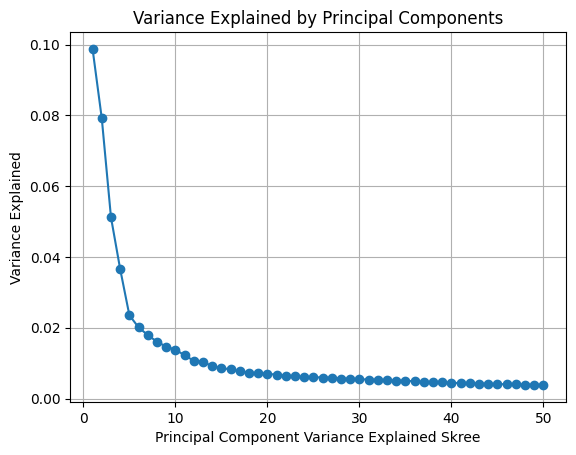

In [36]:
# Make a skree plot of the varianced explained
# Looks like the first 5 or 6 Components are most significant
pca_variance_ratios = pca.explained_variance_ratio_[:50]

plt.plot(range(1, len(pca_variance_ratios) + 1), pca_variance_ratios, marker='o')
plt.xlabel('Principal Component Variance Explained Skree')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()

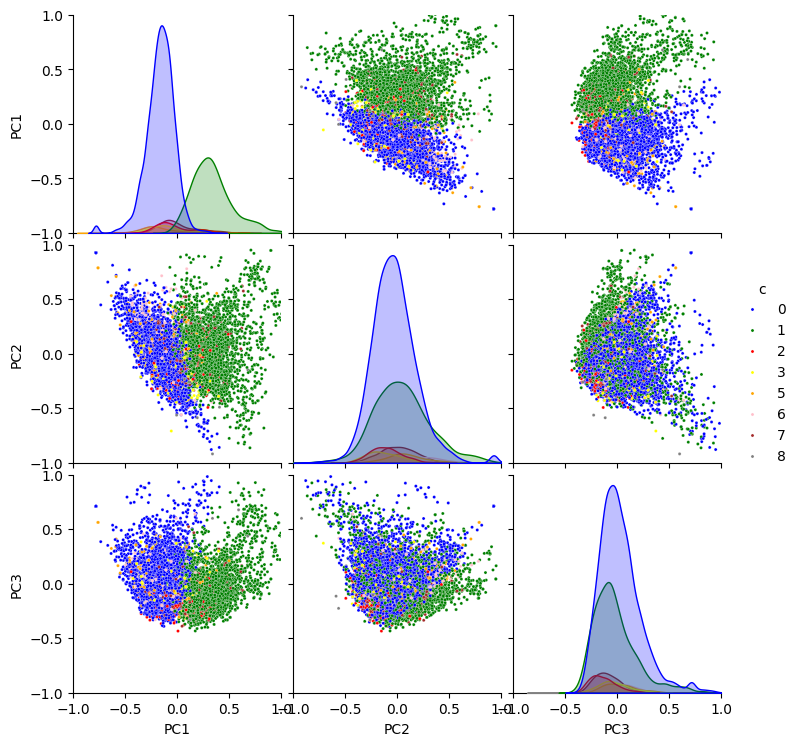

In [37]:
# Let's plot PC1, PC2, PC3 in a pairplot to see what we can see.

# Get a random sample of the points, the cloud is too dense to see structure otherwise
sample_size = 10000
indices = np.random.choice(principal_components.shape[0], sample_size, replace=False)
# Sample rows from the array using the indices
sampled_rows = principal_components[indices]

pc1 = sampled_rows[:, 0]
pc2 = sampled_rows[:, 1]
pc3 = sampled_rows[:, 2]
c = tweet_naive_cats.iloc[indices]

# Create a DataFrame from the principal components
df = pd.DataFrame({'PC1': pc1, 'PC2': pc2, 'PC3': pc3, 'c': c})

# cats = ['climate','warming','people','trump','politic','environment','energy','world', None]
# colors for naive cats
custom_palette = {
    0: 'blue', # climate
    1: 'green', # warming
    2: 'red', # people
    3: 'yellow', # trump
    4: 'purple', # politic
    5: 'orange', # environment
    6: 'pink', # energy
    7: 'brown', # world
    8: 'grey' # None
}

# Create a pairplot of the principal components
pair_plot = sns.pairplot(df, hue='c', palette=custom_palette, plot_kws={'s': 5})
# Manually set the same limits for all axes
for ax in pair_plot.axes.flatten():
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
plt.show()

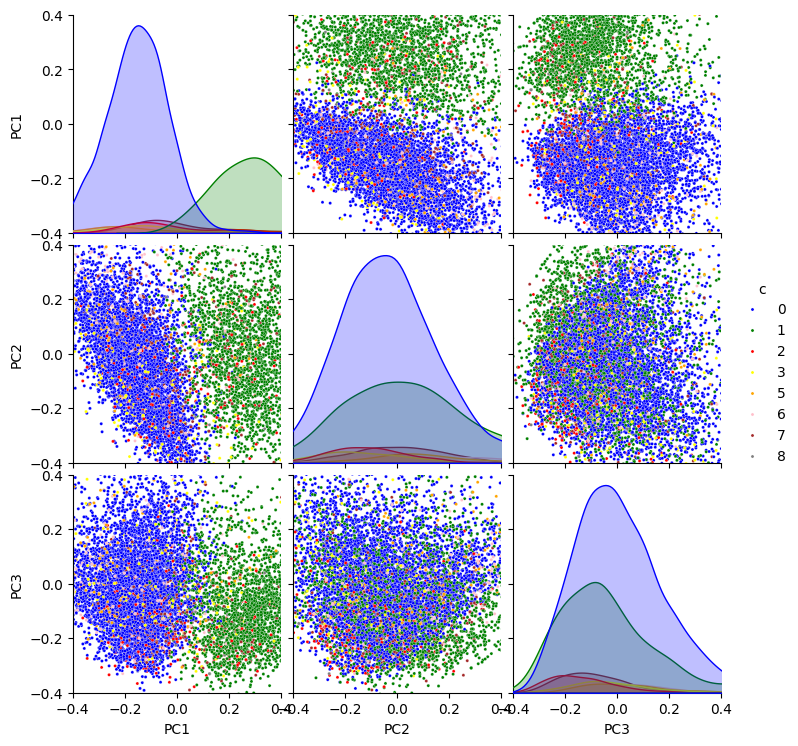

In [38]:
# The predominant structure comes from 'climate'/'change' and 'global'/'warming'
# We can see some other structure from the other categories also
# Let's 'zoom in' on the core of these clusters to see if there's more structure there

# Create a pairplot of the principal components
pair_plot = sns.pairplot(df, hue='c', palette=custom_palette, plot_kws={'s': 5})
# Manually set the same limits for all axes
for ax in pair_plot.axes.flatten():
    ax.set_xlim(-.4, .4)
    ax.set_ylim(-.4, .4)
plt.show()

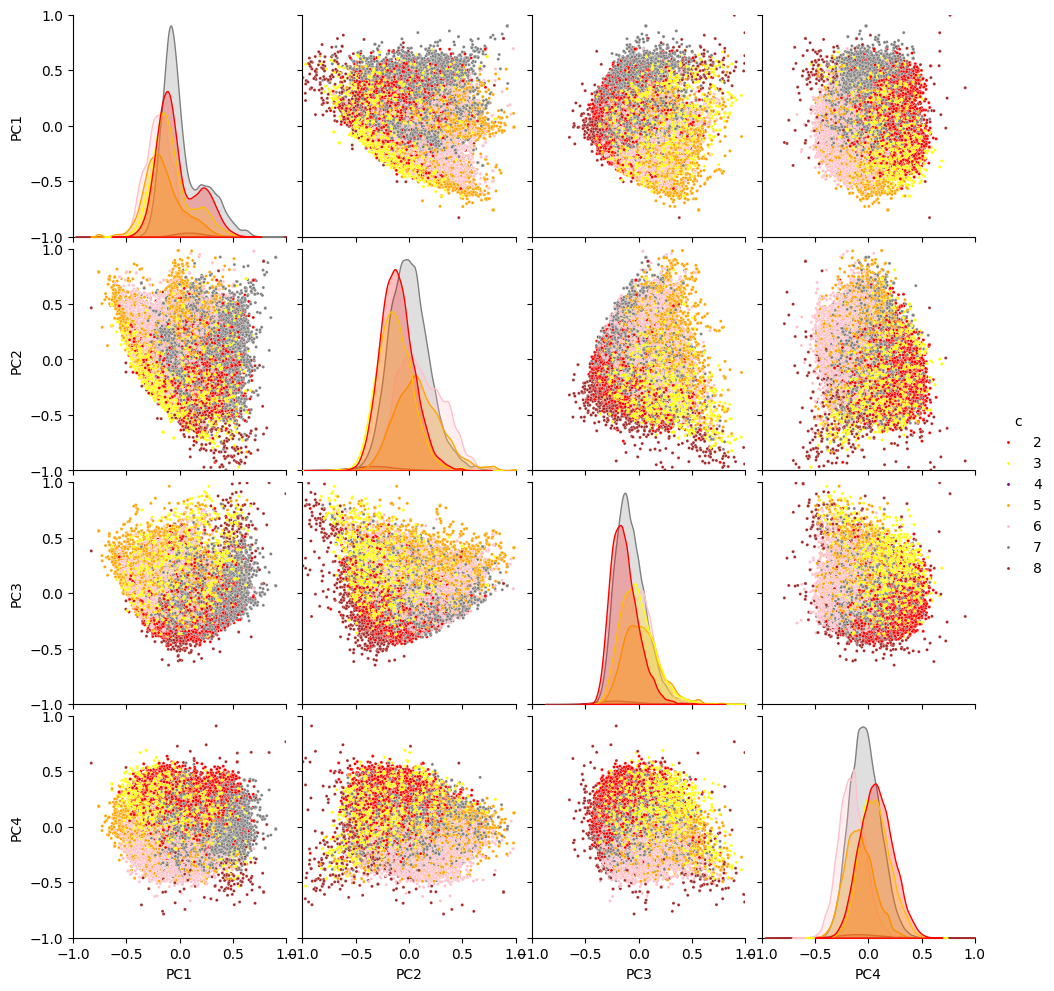

In [39]:
# Let's pairplot only the categories not including 'climate'/'warming'
# This way we have a better picture of the structure of the other categories.
# add some more components as secondary categories may be modeled by lower PCs

# Notes:
# - There seems to be some pretty strong structure here!
# - This suggests that the top most common tokens carry some pretty useful info
#   which could be used for clustering

indices = tweet_naive_cats > 1
# Sample rows from the array using the indices
sampled_rows = principal_components[indices]

pc1 = sampled_rows[:, 0]
pc2 = sampled_rows[:, 1]
pc3 = sampled_rows[:, 2]
pc4 = sampled_rows[:, 3]
c = tweet_naive_cats[indices]

# Create a DataFrame from the principal components
df = pd.DataFrame({'PC1': pc1, 'PC2': pc2, 'PC3': pc3, 'PC4':pc4, 'c': c})

# colors for naive cats
custom_palette = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'yellow',
    4: 'purple',
    5: 'orange',
    6: 'pink',
    7: 'gray',
    8: 'brown'
}

# Create a pairplot of the principal components
pair_plot = sns.pairplot(df, hue='c', palette=custom_palette, plot_kws={'s': 5})
# Manually set the same limits for all axes
for ax in pair_plot.axes.flatten():
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
plt.show()

In [76]:
# Let's apply TF-IDF to get a better understanding of key tokens
# since the documents are so short,
# there would likely usually only be a single instance of a term in a document
# This means we're mostly measuring: How short a doc is wrt How rare a term is.
# tfidf = 1 / len(doc) * log( 1m / #(docs w token) )
# tfidf = 1 / ~14 * log( 1m / #(docs w token) )
# I'm not entirely sure how useful this is, but perhaps we'll get something of it

# Keep only unqique tokens per doc
unique_tokens_sr = filtered_tokens_sr.apply(lambda tokens: list(set(tokens)))
# All unique tokens per doc
unique_doc_tokens = [token for tokens in unique_tokens_sr.tolist() for token in tokens]
# N docs containing each token
token_doc_freqs = FreqDist(unique_doc_tokens)

In [77]:
# Compute tfidf / token
def tfidf(token_doc_freqs, n_docs, doc, token):
  eps = .0000001
  n_token_in_doc = doc.count(token)
  n_docs_with_token = token_doc_freqs[token]
  tf = n_token_in_doc / len(doc)
  idf = np.log( n_docs / (n_docs_with_token+eps))
  return tf * idf

n_docs = len(filtered_tokens_sr)
tokens_tfidf_sr = filtered_tokens_sr.apply(lambda tokens:[tfidf(token_doc_freqs, n_docs, tokens, t) for t in tokens])

In [78]:
# Let's get an idea of which tokens have high tf-idf values
max_tfidf = tokens_tfidf_sr.apply(lambda tokens: max(tokens)).max()
print(f'Max tfidf: {max_tfidf}')

Max tfidf: 10.98219420272084


In [87]:
# What is our distribution of tf-idf values?
all_tfidf_scores = pd.Series(tokens_tfidf_sr.explode().tolist())
all_tfidf_scores.describe()

count    1.073042e+07
mean     4.381782e-01
std      3.201811e-01
min      2.812135e-03
25%      2.187071e-01
50%      3.934835e-01
75%      6.010970e-01
max      1.098219e+01
dtype: float64

In [129]:
token_doc_freqs['stalwart']

11

In [83]:
# What would scores in the top 95% percentile look like?
top_tfidf_95 = all_tfidf_scores.quantile(0.95)
print(f'Top 95% tfidf: {top_tfidf_95}')

Top 95% tfidf: 1.012709343352501


In [86]:
all_tokens_sr = pd.Series(filtered_tokens_sr.explode().tolist())

In [90]:
# Build a df of tokens and their tfidfs
tokens_tfidf_df = pd.DataFrame({'tokens':all_tokens_sr, 'tfidf': all_tfidf_scores})

In [91]:
tokens_tfidf_95_df = tokens_tfidf_df[tokens_tfidf_df['tfidf'] > top_tfidf_95]

In [ ]:
# This gives us tokens that are rare-ish that appear several times in their docs
tokens_tfidf_95_df.sort_values(by='tfidf', inplace=True, ascending=False)

In [142]:
# Let's get the mean tf-idf for a token
# I'm not finding much structure here
tokens_tfidf_95_mean_df = tokens_tfidf_95_df.groupby('tokens')['tfidf'].mean()
tokens_tfidf_95_mean_df.sort_values(ascending=False)

tokens
downunder            6.011824
barcode              4.007883
bz                   3.956499
eradicates           3.956499
personnes            3.725450
                       ...   
institutionalized    1.016032
sizable              1.016032
enfants              1.016032
competitive          1.015209
obtained             1.015185
Name: tfidf, Length: 28378, dtype: float64

In [145]:
# What are the tfidfs for our most common tokens?
# Gives us middle 25% quantile low scores
ts = [t for t, cnt in token_doc_freqs.most_common(20)]
tokens_tfidf_mean_df = tokens_tfidf_df.groupby('tokens')['tfidf'].mean()
tokens_tfidf_mean_df.loc[ts]

tokens
climate        0.036076
change         0.038179
global         0.130657
warming        0.138115
via            0.335311
u              0.267671
world          0.284132
ha             0.261670
say            0.304317
people         0.269341
new            0.296816
like           0.283140
year           0.290791
need           0.306534
environment    0.349048
trump          0.318874
wa             0.293522
time           0.310767
energy         0.333762
science        0.317504
Name: tfidf, dtype: float64